In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset
data = pd.read_csv("C:/Sophia/School!!!/2023 Spring 1/DS take home/4.Fraud/Fraud.csv", parse_dates=['signup_time', 'purchase_time'])
data = data.drop(data.columns[0], axis = 1)
ip = pd.read_csv("C:/Sophia/School!!!/2023 Spring 1/DS take home/4.Fraud/IpAddress_to_Country.csv")

In [3]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [7]:
# Determine the country in each row based on the numeric IP address

countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ip[(ip['lower_bound_ip_address'] <= ip_address) & (ip['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Feature Engineering

- Time difference between sign-up time and purchase time
- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
- Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
- Usual week of the year and day of the week from time variables

In [8]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [9]:
# Check user number for unique devices
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [10]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [11]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [12]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,8,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [13]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,8,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [14]:
data.isnull().sum()

signup_day        0
signup_week       0
purchase_day      0
purchase_week     0
purchase_value    0
source            0
browser           0
sex               0
age               0
country           0
time_diff         0
device_num        0
ip_num            0
class             0
dtype: int64

### Machine Learning Models

In [15]:
y = data['class']

In [16]:
len(data[data['class']==1])/len(data)

0.09364577267192546

In [17]:
len(data[data['class']==0])/len(data)

0.9063542273280746

In [18]:
x = data.loc[:, ~data.columns.isin(['class'])]

In [19]:
x.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,8
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1


In [20]:
# Label Encoding: Encode labels with value between 0 and n_classes-1.

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
x['source'] = lb.fit_transform(x['source'])
x['browser'] = lb.fit_transform(x['browser'])
x['sex'] = lb.fit_transform(x['sex'])
x['country'] = lb.fit_transform(x['country'])

In [21]:
x.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num
0,1,9,5,16,34,2,0,1,39,84,13882,1,1
1,6,23,0,24,16,0,0,0,53,172,17944,1,1
2,3,1,3,1,15,2,3,1,53,172,1,12,8
3,1,18,0,19,44,2,4,1,41,115,60085,1,1
4,1,30,2,37,39,0,4,1,45,172,41461,1,1


In [22]:
# Splitting data into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=12)

##### Logistic Regression

In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_scaled_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_scaled_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [24]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_scaled_train, y_train)

LogisticRegression()

In [25]:
predictions = logmodel.predict(X_scaled_test)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    109623
           1       0.91      0.53      0.67     11267

    accuracy                           0.95    120890
   macro avg       0.93      0.76      0.82    120890
weighted avg       0.95      0.95      0.95    120890



In [28]:
print(confusion_matrix(y_test,predictions))

[[109041    582]
 [  5298   5969]]


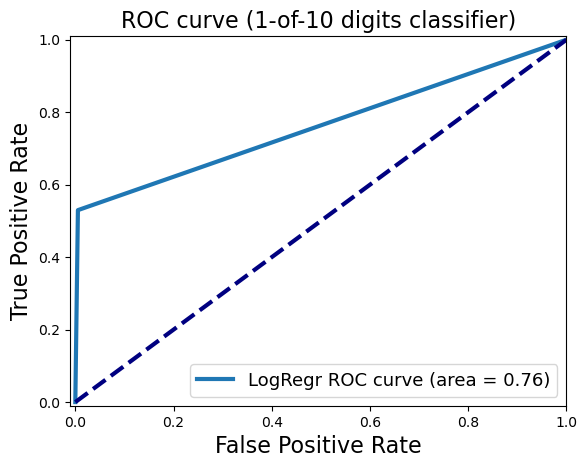

In [29]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

In [30]:
y_pred_prob = logmodel.predict_proba(X_scaled_test)[:,1]

In [31]:
from sklearn.metrics import average_precision_score, precision_recall_curve
# Average precision score
average_precision = average_precision_score(y_test, y_pred_prob)
print(average_precision)

0.6679736123534789


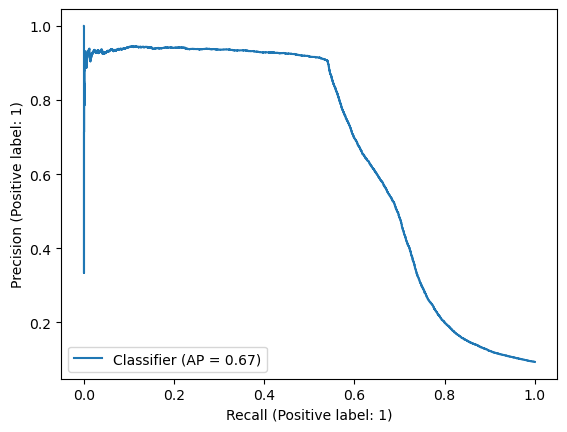

In [32]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob)

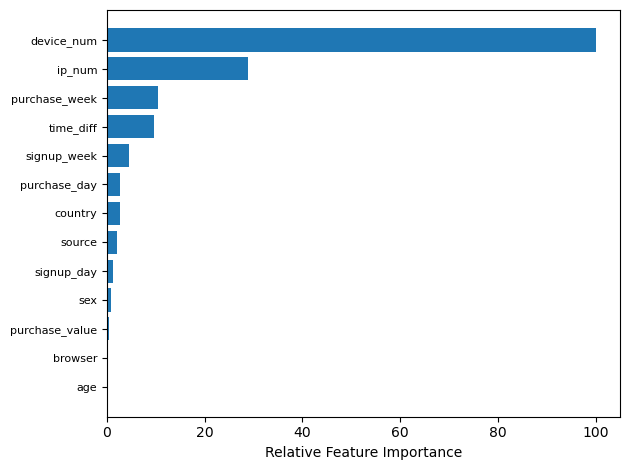

In [33]:
feature_importance = abs(logmodel.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()  

##### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfc = RandomForestClassifier(n_estimators=600)

In [36]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

In [37]:
predictions = rfc.predict(X_test)

In [38]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    109623
           1       1.00      0.54      0.70     11267

    accuracy                           0.96    120890
   macro avg       0.98      0.77      0.84    120890
weighted avg       0.96      0.96      0.95    120890



In [39]:
print(confusion_matrix(y_test,predictions))

[[109618      5]
 [  5217   6050]]


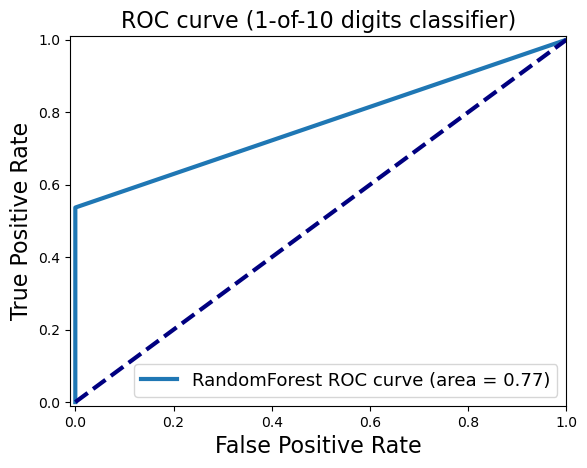

In [40]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='RandomForest ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

In [41]:
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [42]:
# Average precision score
average_precision = average_precision_score(y_test, y_pred_prob)
print(average_precision)

0.7149442528495226


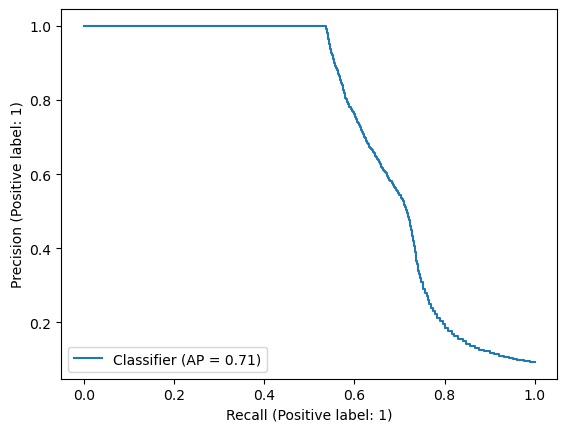

In [43]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob)

In [44]:
rfc.feature_importances_

array([0.0316836 , 0.07561083, 0.03135537, 0.15262669, 0.06277928,
       0.01668081, 0.02179168, 0.0106942 , 0.05650284, 0.03838688,
       0.25268937, 0.12707272, 0.12212573])

Text(0.5, 0, 'Random Forest Feature Importance')

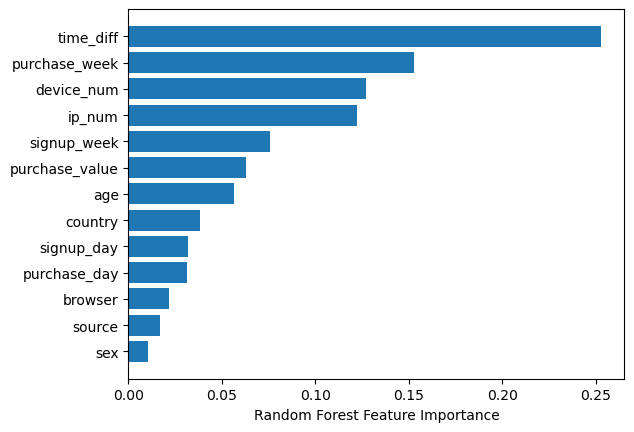

In [45]:
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

##### Support Vector Machines

In [46]:
from sklearn.svm import SVC

In [47]:
svc_model = SVC(probability=True)

In [48]:
svc_model.fit(X_train,y_train)

SVC(probability=True)

In [49]:
predictions = svc_model.predict(X_test)

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    109623
           1       0.66      0.55      0.60     11267

    accuracy                           0.93    120890
   macro avg       0.81      0.76      0.78    120890
weighted avg       0.93      0.93      0.93    120890



In [51]:
print(confusion_matrix(y_test,predictions))

[[106411   3212]
 [  5054   6213]]


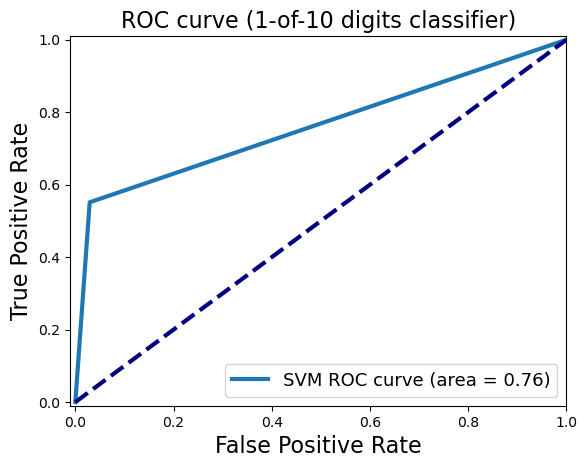

In [52]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='SVM ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

In [53]:
y_pred_prob = svc_model.predict_proba(X_test)[:,1]

In [54]:
# Average precision score
average_precision = average_precision_score(y_test, y_pred_prob)
print(average_precision)

0.6275384443807662


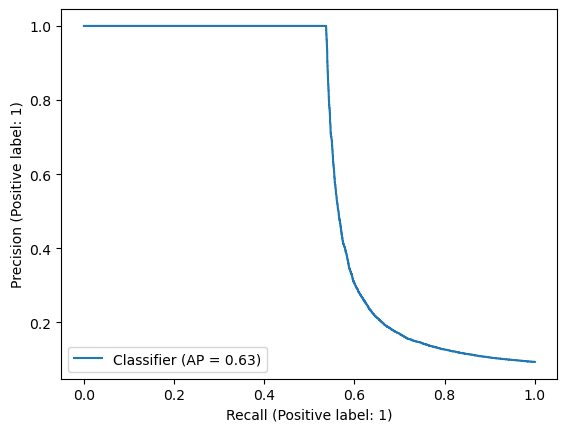

In [55]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob)

##### Impact of FP vs. FN
- if ** false positive ** cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
- if ** false negative ** cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

In this case, the "Fraud Detection Model" is often used in a pre-screening step, which means that the result will be further investigated by expert, so

- if 'Not Fraud' is classified as 'Fraud', human expert can fix the problem,
- but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.

##### Hence, in this case, "false negative" cost much higher. We should choose a relatively smaller threshold.

The outcomes of recall(True Positive Rate) are similar in three models. However, Random Forest has better performance based on the higher AUC under Precision-Recall curve and ROC curve.